In [ ]:
import os
from haystack_integrations.document_stores.weaviate import WeaviateDocumentStore, AuthApiKey

In [17]:
from haystack import Pipeline
from haystack.components.embedders import OpenAITextEmbedder
from haystack.components.generators import OpenAIGenerator
from haystack.components.builders import PromptBuilder
from haystack_integrations.components.retrievers.weaviate import WeaviateEmbeddingRetriever

In [18]:
# Let's setup weaviate.
auth_client_secret = AuthApiKey()

document_store = WeaviateDocumentStore(
    url="https://zgvjwlycsr6p5j1ziuyea.c0.europe-west3.gcp.weaviate.cloud",
    auth_client_secret=auth_client_secret
)

In [19]:
template = """Given the information below, answer the query. Only use the 
provided context to generate the answer

    Context:

    {% for document in documents %}
        {{ document.content }}
    {% endfor %}

    Question: {{ query }}
    
    Answer:
"""

In [20]:
text_embedder = OpenAITextEmbedder(model="text-embedding-3-small")
retriever = WeaviateEmbeddingRetriever(document_store=document_store, top_k=5)
prompt_builder = PromptBuilder(template=template)
generator = OpenAIGenerator()

In [21]:
# Let's setup extractive QA pipeline.
rag = Pipeline()

# Add components to your pipeline
rag.add_component("text_embedder", text_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt_builder", prompt_builder)
rag.add_component("llm", generator)

# Now, connect the components to each other
rag.connect("text_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever", "prompt_builder.documents")
rag.connect("prompt_builder", "llm")

🚅 Components
  - text_embedder: OpenAITextEmbedder
  - retriever: WeaviateEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

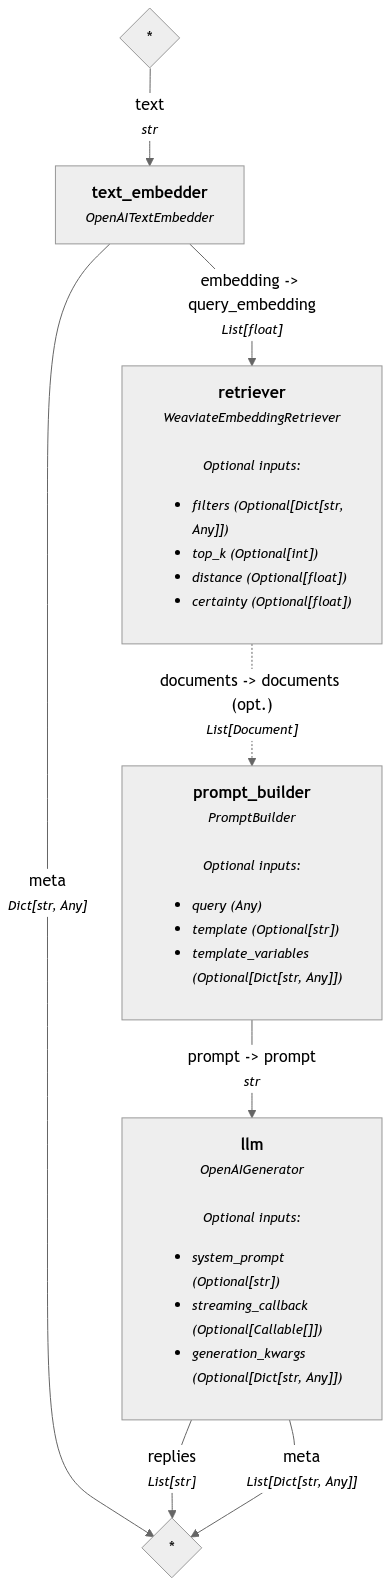

In [22]:
rag.show()

In [23]:
query = "What happens in the film 'A Very Weaviate Christmas'?"
reply = rag.run(data={
    "text_embedder": {"text": query},
    "prompt_builder": {"query": query}
})

In [24]:
reply["llm"]["replies"]

['In the film \'A Very Weaviate Christmas,\' we follow the thrilling adventures of two of Santa\'s elves, Daniel and Philip, as they embark on a mission to recover stolen vectors that an intruder has hidden in an unknown Collection. Their journey is urgent as they strive to find the missing vectors in "Santas_Grotto" before Christmas Day. The film features the Weaviate DevRel and Growth teams.']

In [25]:
import weaviate

from weaviate.classes.init import Auth

headers = {"X-OpenAI-Api-Key": os.getenv("OPENAI_API_KEY")}
client = weaviate.connect_to_weaviate_cloud(
    cluster_url="https://zgvjwlycsr6p5j1ziuyea.c0.europe-west3.gcp.weaviate.cloud",
    auth_credentials=Auth.api_key(os.getenv("WEAVIATE_API_KEY")),
    headers=headers
)

In [26]:
# Provide the name of the collection in client.collections.get() below 👇
plot = client.collections.get("Santas_Grotto")

In [27]:
for item in plot.iterator(include_vector=True):
    print(item.properties)
    print(item.vector)

{'plot': 'Tuana is here with not just all the vectors but also all the presents that are supposed to be delivered around the World!', 'decoy': False}
{'default': [-0.01721211150288582, 0.04526200518012047, 0.018081987276673317, -0.0271229799836874, 0.00044875199091620743, -0.039415307343006134, 0.011985733173787594, 0.021689826622605324, -0.0182958897203207, -0.051450952887535095, -0.04403562471270561, 0.006748659536242485, -0.013732613064348698, -0.04269516468048096, 0.035793207585811615, -0.01665596291422844, -0.05070941895246506, 0.02387164533138275, 0.007600708864629269, 0.03927270695567131, 0.05053829774260521, -0.022459881380200386, -0.0007473257719539106, -0.004880567546933889, -0.0007709442870691419, 0.012320849113166332, -0.023942945525050163, 0.053076617419719696, 0.08322276920080185, 0.0707307979464531, -0.005233508534729481, -0.037732597440481186, 0.014203201048076153, -0.015629224479198456, 0.026438487693667412, 0.03476646915078163, -0.028078416362404823, 0.012755786068737